# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

#from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [24]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

Clear previously loaded data.


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [25]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [26]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-8, 5e-8, 1e-7, 5e-6, 1e-6]
regularization_strengths = [5e4, 5e5, 5e6, 1e5]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                              num_iters=1000, verbose=True)
        
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        
        if (best_val < val_acc):
            best_val = val_acc
            best_svm = svm
        results[(lr, reg)] = (train_acc, val_acc)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 85.042477
iteration 100 / 1000: loss 71.260763
iteration 200 / 1000: loss 59.966627
iteration 300 / 1000: loss 50.718375
iteration 400 / 1000: loss 43.157830
iteration 500 / 1000: loss 36.966059
iteration 600 / 1000: loss 31.890643
iteration 700 / 1000: loss 27.732818
iteration 800 / 1000: loss 24.339127
iteration 900 / 1000: loss 21.555290
iteration 0 / 1000: loss 809.598503
iteration 100 / 1000: loss 116.269687
iteration 200 / 1000: loss 23.372175
iteration 300 / 1000: loss 10.925267
iteration 400 / 1000: loss 9.257643
iteration 500 / 1000: loss 9.034449
iteration 600 / 1000: loss 9.004571
iteration 700 / 1000: loss 9.000596
iteration 800 / 1000: loss 9.000054
iteration 900 / 1000: loss 8.999977
iteration 0 / 1000: loss 7717.027014
iteration 100 / 1000: loss 9.000003
iteration 200 / 1000: loss 8.999996
iteration 300 / 1000: loss 8.999997
iteration 400 / 1000: loss 8.999997
iteration 500 / 1000: loss 8.999997
iteration 600 / 1000: loss 8.999996
iteration 700 /

/home/danger/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:77: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/home/danger/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/danger/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:77: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf


/home/danger/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:95: RuntimeWarning: overflow encountered in multiply
  dW += reg * 2 * W
/home/danger/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:74: RuntimeWarning: invalid value encountered in maximum
  margins = np.maximum(0, scores - scores_yi + 1)
/home/danger/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:89: RuntimeWarning: invalid value encountered in greater
  map[map > 0] = 1 # map of if loss has no zero value


iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 7709.736898
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
iteration 0 / 1000: loss 163.262223
iteration 100 / 1000: loss 8.999948
iteration 200 / 1000: loss 8.999991
iteration 300 / 1000: loss 8.999964
iteration 400 / 1000: loss 8.999965
iteration 500 / 1000: loss 9.000029
iteration 600 / 1000: loss 8.999954
iteration 700 / 1000: loss 9.000075
iteration 800 / 1000: loss 9.000008
iteration 900 / 1000: loss 8.999993
iteration 0 / 1000: loss 83.111858
iteration 100 / 1000: loss 8.999641
iteration 200 / 1000: loss 8.999701
iteration 300 / 1000: loss 8.999622
iteration 400 / 1000: loss 8.999578
iteration 500 / 1000:

In [27]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.421


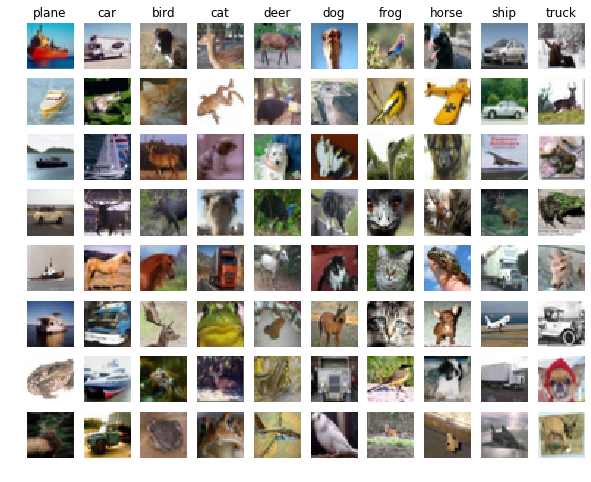

In [29]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?
Yes, for example plane classifier has a lot of imagies of ships beacause there are a lot of blue color

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [30]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [59]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
input_dim = X_train_feats.shape[1]
hidden_size = [250, 150, 200]
learning_rates = [2.35e-1, 2.5e-1, 2.65e-1, 3e-1, 2e-1]
regularisation_rate = [5e-5, 1e-4, 1e-5]
num_classes = 10
best_acc = -1
results = {}

for hid in hidden_size:
    for lr in learning_rates:
        for reg in regularisation_rate:
            
            net = TwoLayerNet(input_dim, hid, num_classes)
            
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                        num_iters=1000, batch_size=200,
                        learning_rate=lr, learning_rate_decay=0.95,
                        reg=reg, verbose=True)

            y_train_pred = net.predict(X_train_feats)
            train_acc = np.mean(y_train == y_train_pred)
            # Predict on the validation set
            val_acc = (net.predict(X_val_feats) == y_val).mean()
            print('Validation accuracy: ', val_acc)
            if val_acc > best_acc:
                best_acc = val_acc
                best_est = net
            results[(lr, reg, hid)] = (train_acc, val_acc)

for lr, reg, hid in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, hid)]
    print('lr %e reg %e hid %e train accuracy: %f val accuracy: %f' % (
                lr, reg, hid, train_accuracy, val_accuracy))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.076275
iteration 200 / 1000: loss 1.506527
iteration 300 / 1000: loss 1.395906
iteration 400 / 1000: loss 1.385884
iteration 500 / 1000: loss 1.358616
iteration 600 / 1000: loss 1.295433
iteration 700 / 1000: loss 1.263183
iteration 800 / 1000: loss 1.151714
iteration 900 / 1000: loss 1.347606
Validation accuracy:  0.542
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.060883
iteration 200 / 1000: loss 1.455165
iteration 300 / 1000: loss 1.409713
iteration 400 / 1000: loss 1.406704
iteration 500 / 1000: loss 1.314248
iteration 600 / 1000: loss 1.297017
iteration 700 / 1000: loss 1.296543
iteration 800 / 1000: loss 1.256048
iteration 900 / 1000: loss 1.364042
Validation accuracy:  0.527
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.100870
iteration 200 / 1000: loss 1.439505
iteration 300 / 1000: loss 1.518575
iteration 400 / 1000: loss 1.388527
iteration 500 / 1000: loss 1.504547
iteration 600 

iteration 300 / 1000: loss 1.409002
iteration 400 / 1000: loss 1.405616
iteration 500 / 1000: loss 1.209959
iteration 600 / 1000: loss 1.250143
iteration 700 / 1000: loss 1.196565
iteration 800 / 1000: loss 1.184725
iteration 900 / 1000: loss 1.392221
Validation accuracy:  0.544
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.055524
iteration 200 / 1000: loss 1.533506
iteration 300 / 1000: loss 1.377097
iteration 400 / 1000: loss 1.458079
iteration 500 / 1000: loss 1.310428
iteration 600 / 1000: loss 1.260739
iteration 700 / 1000: loss 1.266349
iteration 800 / 1000: loss 1.224235
iteration 900 / 1000: loss 1.276250
Validation accuracy:  0.555
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.960708
iteration 200 / 1000: loss 1.555826
iteration 300 / 1000: loss 1.338239
iteration 400 / 1000: loss 1.285239
iteration 500 / 1000: loss 1.290098
iteration 600 / 1000: loss 1.367361
iteration 700 / 1000: loss 1.357715
iteration 800 / 1000: loss 1.330562
iteration 90

iteration 600 / 1000: loss 1.152096
iteration 700 / 1000: loss 1.408722
iteration 800 / 1000: loss 1.165386
iteration 900 / 1000: loss 1.292201
Validation accuracy:  0.536
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.209980
iteration 200 / 1000: loss 1.718216
iteration 300 / 1000: loss 1.425322
iteration 400 / 1000: loss 1.380292
iteration 500 / 1000: loss 1.333928
iteration 600 / 1000: loss 1.323024
iteration 700 / 1000: loss 1.199882
iteration 800 / 1000: loss 1.323977
iteration 900 / 1000: loss 1.296025
Validation accuracy:  0.541
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.220987
iteration 200 / 1000: loss 1.529204
iteration 300 / 1000: loss 1.504934
iteration 400 / 1000: loss 1.296437
iteration 500 / 1000: loss 1.284466
iteration 600 / 1000: loss 1.426192
iteration 700 / 1000: loss 1.431258
iteration 800 / 1000: loss 1.329831
iteration 900 / 1000: loss 1.350921
Validation accuracy:  0.532
lr 2.000000e-01 reg 1.000000e-05 hid 1.500000e+02 train 

In [72]:
np.sort(np.array(list(results.values()))[:, 1])

array([0.527, 0.53 , 0.531, 0.532, 0.532, 0.533, 0.536, 0.536, 0.536,
       0.537, 0.537, 0.539, 0.539, 0.539, 0.539, 0.54 , 0.541, 0.542,
       0.543, 0.544, 0.544, 0.544, 0.545, 0.546, 0.546, 0.546, 0.547,
       0.549, 0.549, 0.549, 0.55 , 0.55 , 0.55 , 0.551, 0.552, 0.554,
       0.555, 0.556, 0.558, 0.558, 0.56 , 0.56 , 0.561, 0.565, 0.567])

In [74]:
"""lr 3.000000e-01 reg 1.000000e-05 hid 2.500000e+02 trai"""
net = TwoLayerNet(input_dim, 250, num_classes)
            
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                        num_iters=1000, batch_size=200,
                        learning_rate=3e-1, learning_rate_decay=0.95,
                        reg=1e-5, verbose=True)

iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.865686
iteration 200 / 1000: loss 1.424205
iteration 300 / 1000: loss 1.354124
iteration 400 / 1000: loss 1.530264
iteration 500 / 1000: loss 1.319019
iteration 600 / 1000: loss 1.370093
iteration 700 / 1000: loss 1.335065
iteration 800 / 1000: loss 1.291437
iteration 900 / 1000: loss 1.227181


In [76]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_est.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.547
